# Pseudo Dry Gas Modelling

this notebook deals with modelling of pseudo dy system. Calculations could be immediately tested and result shown on the graphs. When agreed that the calculations are correct we will move this to Offshore Constuctor. 

In [4]:
from __future__ import print_function
import numpy as np
import math
import json
import tsp
import pandas as pd
import shapely.geometry as geometry
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import sklearn.neighbors

## Test data

In [5]:
pArrival = 70*10**5

In [6]:
# control points from the line
points = [{'x': 0.0, 'y': 0.12, 'z': 54.0546},
  {'x': 927.7, 'y': 32758.0, 'z': -99.0},
  {'x': -28471.08, 'y': 113337.86, 'z': -704.0},
  {'x': -55703.16, 'y': 165663.44, 'z': -1640.0},
  {'x': -39675.55, 'y': 171925.05, 'z': -1564.0}]
manifolds = points[-3:]
endPoint = [points[0]]
manifolds, endPoint

([{'x': -28471.08, 'y': 113337.86, 'z': -704.0},
  {'x': -55703.16, 'y': 165663.44, 'z': -1640.0},
  {'x': -39675.55, 'y': 171925.05, 'z': -1564.0}],
 [{'x': 0.0, 'y': 0.12, 'z': 54.0546}])

Path lenght connecting all points is 194742.6263587469 m


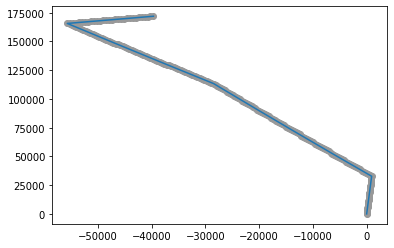

In [7]:
from shapely.geometry import Point, Polygon, LineString
import matplotlib.pyplot as plt
from matplotlib import pyplot
with open('baseLine.json', "r") as json_file:
    data=json_file.read()
    _line = json.loads(data)
    line_points =[(x["x"],x["y"],x["z"]) for x in _line] 
path=LineString(line_points)
print(f"Path lenght connecting all points is {path.length} m")
_cumkp=0
kp=[]
for index, point in enumerate(line_points):
    if index == 0: 
        kp.append(0)  
        continue
    _kp = math.sqrt( (line_points[index][0]-line_points[index-1][0])**2 + 
                   (line_points[index][1]-line_points[index-1][1])**2 + 
                   (line_points[index][2]-line_points[index-1][2])**2 )
    _cumkp = _cumkp + _kp 
    kp.append(_cumkp)
x,y = path.xy
plt.plot(x,y);
pyplot.plot(x, y, 'o', color='#999999', zorder=1)

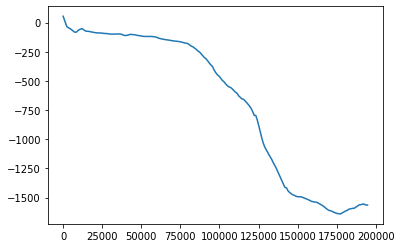

In [8]:
# allignment sheet
plt.plot(kp,[x["z"] for x in _line])

In [9]:
# here for simplification purpose we use only one line. In Offshore Constructor it is splitted to PLET-PLET. 
line = { 'smys': 448000000.0,
 'wallThickness': 0.01588,
 'points': _line}
line["length"]= path.length
line["pipeRoughness"]= 0.0045 
line["angle"] = -90
line["corrosionAllowance"] = 0.003


In [10]:
#fluid data
fluid = {
    "temperature": 110,
    "flowRate": 500,
    "pressure": 180*10**5,
    "density": 2.2,
    "viscosity": 200*10e-6,
    "heatCapapcity": 2.31,
    "thermalConductivity": 0.035,
    "Compressibility  Factor": 1,
    "description": ["COMPOSITION onecomponent = ON","library name=\"Methane\" comp=1"]
}

## CASES
### Wells locations known
Positions of wells are put in excel together with all properties of the wells, including the fluid data.
#### Determining manifold locations
User to specify number of manifolds and algorithm to find number of clusters equal to number of manifolds.
As a first try place manifolds in the centre of the cluster. 

### Wells locations unknown
Here we place one manifold per reservoir and allow user to place a number of wells per reservoir and 
distance from the manifold. Algorithm randomly places wells around the manifold at the user specified distance. 


## Functions

In [14]:
def getPointsFromSpline(filename):
    points=[]
    no=0
    j=10000
    x0 = 428.9
    y0 = 61.61
    scale_x = 469.866769
    scale_y = 365.285025
    with open(filename, "r") as f:
        _raw = f.readlines()
        for i, line in enumerate(_raw):
            if "Number of control points:" in line:
                no = int(line.split(": ")[1])
                j=0
                _points=[]
                continue
            if j<int(no):
                _p = line.replace("X = ","").replace("Y = ","").replace("Z = ","").replace("Control Points: ","").strip().split(",")
                j+=1
                point = ((float(_p[0])-x0)*scale_x,(float(_p[1])-y0)*scale_y)
                _points.append(point)
                if j==no-1:
                    points.append(_points)
    print(f"Imported {len(points)} splines")
    from shapely import geometry
    import matplotlib.pyplot as plt
    for i, rpoints in enumerate(points):
        poly = geometry.Polygon([[p[0], p[1]] for p in rpoints])
        x,y = poly.exterior.xy
        plt.plot(x,y);
    plt.show()
    return points
def random_wells_in_polygon(number, polygon):
    import random
    from shapely.geometry import Point
    list_of_points = []
    minx, miny, maxx, maxy = polygon.bounds
    counter = 0
    while counter < number:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            list_of_points.append(pnt)
            counter += 1
    return list_of_points
def testManifoldLocations(wells, maxNum):
    items_df = pd.DataFrame()
    m_l=[]
    if maxNum%3==0: col = 3
    else: col = 2
    row= round(maxNum/col)
    fig, ax = plt.subplots(nrows=row, ncols=col)
    SIZE = (15,20)
    fig.set_size_inches(SIZE)
    i=0
    for row in ax:
        for col in row:
            i+=1
            kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
            pred_y = kmeans.fit_predict(wells)
            m_ix = kmeans.fit_predict(wells)
            m_loc = kmeans.cluster_centers_
            m_l.append({"noOfManifolds": i, "locations:":m_loc})
            _items_df=connectSystem(wells, m_loc, m_ix)
            items_df = items_df.append(_items_df,ignore_index=True, sort=False)
            col.scatter(wells[:,0], wells[:,1])
            col.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
            col.set_xlabel(f'{i} manifolds', labelpad = 5)
    plt.show()   
    return m_l
'''
Plotting code
'''

from matplotlib import pyplot
from shapely.figures import SIZE, set_limits, plot_coords, plot_bounds, plot_line_issimple
from shapely.geometry import Point, Polygon, LineString

COLOR = {
    True:  '#6699cc',
    False: '#ffcc33'
    }

def v_color(ob):
    return COLOR[ob.is_simple]

def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, 'o', color='#999999', zorder=1)

def plot_bounds(ax, ob):
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    ax.plot(x, y, 'o', color='#000000', zorder=1)

def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, color=v_color(ob), alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

def plot_df(items_df):
    SIZE = (10,10)
    fig = pyplot.figure(1, figsize=SIZE, dpi=90)

    for case_ix, case in enumerate(items_df["case"].unique()):
        case_m=items_df["case"]==case
        l_m=items_df["Element"]=="l"
        mask= case_m & l_m
        ax = fig.add_subplot(321+case_ix)


        for i in range(items_df[mask]["Element"].count()):
            line = items_df[mask]["positions"].values[i]

            plot_coords(ax, line)
            plot_bounds(ax, line)
            plot_line_issimple(ax, line, alpha=0.7)

        ax.set_title(case)

    pyplot.show()
def connect(point1, point2):
    '''
    takes 2 points and returns line object
    '''
    firstPoint = point1
    lastPoint = point2
#     findPath HOLD
    path = [firstPoint,lastPoint]
    l=LineString(path)
    return l
def connectSystem(w_loc, m_loc=[], m_ix=[], ep_loc=[float(0),float(0)]):
    '''
    Connects all wells to the nearest manifold or end point. Then connectes all manifolds and end point. 
    Returns a dataframe with lines and lengths and manifolds and number of connections to every manifold. 
    
    :param w_loc: list of well locations [[x1,y1,z1],...[xn,yn,zn]]
    :param m_loc: numpy array of position of manifolds
    :paramm_ix: numpy array of index showing cluster number for every well
    :paramep_loc: location of end point
    '''
    l=[]
    _d={"Element": [],
          "qty": [],
          "positions": [],
          "case":[]}
    
    # treat clusters and end point as connecting nodes, in order to find best connections
    eps=m_loc #THE ONLY DIFFERENCE MERGE - HOLD
    eps = np.vstack([eps, ep_loc])

    # find nearest cluster to connect wells to
    tree = sklearn.neighbors.KDTree(eps)
    # this connects all wells with the nearest cluster point
    # needs a verification if the nearest is also the one chosen by the cluster HOLD
    for w in w_loc:    
        d, i = tree.query([w])
        new_origin = tree.get_arrays()[0][i[0][0]]
        distance = d[0][0]
        l.append(connect(w,new_origin))


    # now we need to connect all cluster points by excluding the current cp from the possible connections    
    for kk, ep in enumerate(eps):
#         print("eps",eps, eps.shape)
#         print("ep",ep, ep.shape)

        if eps.shape[0] == 1: 
            continue

        eps_m = np.delete(eps,kk,0)
        tree = sklearn.neighbors.KDTree(eps_m)
        d, i = tree.query([ep])
        new_origin = tree.get_arrays()[0][i[0][0]]
        distance = d[0][0]
#         print(f"From node {ep} closest node is {new_origin} with distance {distance}")
#         print(f"Nodes list to choose closest is {eps_m}")
        l.append(connect(ep,new_origin))
    
     # put data in dataframe
    for item in l:
        _d["Element"]= _d["Element"] + ["l"]
        _d["qty"]= _d["qty"]+ [item.length]
        _d["positions"]=_d["positions"]+ [item]
        _d["case"]=_d["case"]+ ["m="+str(len(m_loc))]
    for m in m_loc:
        _d["Element"]= _d["Element"] + ["m"]
        count=0
        for item in l:
            if (m == item.coords[0]).all() or (m==item.coords[-1]).all():
                count+=1
#                 print(f"M {m} connects line from {item.coords[0]} to {item.coords[-1]}")
#         print(f" case {str(len(m_loc))} m {m} has {count} connections")
        _d["qty"]= _d["qty"]+ [count]
        _d["positions"]=_d["positions"]+ [m]
        _d["case"]=_d["case"]+ ["m="+str(len(m_loc))]
    df = pd.DataFrame(_d)

    return df
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    
    path = []
    max_route_distance = 0
    sum_route_distance = 0
    for vehicle_id in range(data['num_lines']):
        _path = {}
        index = routing.Start(vehicle_id)
        plan_output = 'Route for line {}:\n'.format(vehicle_id)
        _path["line"] = vehicle_id
        route_distance = 0
        _pathL = []
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            _pathL.append(data["locations"][manager.IndexToNode(index)])
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        _path["path"] =  _pathL
        _path["distance"] = route_distance
        path.append(_path)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
#         print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
        sum_route_distance += route_distance
#     print('Maximum of the route distances: {}m'.format(max_route_distance))
#     print('Sum of the route distances: {}m'.format(sum_route_distance))
    return path, sum_route_distance

# [START distance_callback]
def compute_euclidean_distance_matrix(locations):
    """Creates callback to return distance between points."""
    distances = {}
    for from_counter, from_node in enumerate(locations):
        distances[from_counter] = {}
        for to_counter, to_node in enumerate(locations):
            if from_counter == to_counter or to_counter == 0:
                distances[from_counter][to_counter] = 0
            else:
                # Euclidean distance
                distances[from_counter][to_counter] = (int(
                    math.hypot((from_node[0] - to_node[0]),
                               (from_node[1] - to_node[1]))))
    return distances
    # [END distance_callback]
def create_data_model(points_2dList, noOfLines):
    """Stores the data for the problem."""
    data = {}
    
    data['locations'] = points_2dList
    data['num_lines'] = noOfLines
    data['depot'] = 0
#     print(data)
    return data
def getPath(points_2dList, noOfLines, maxLength=200000):
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model(points_2dList, noOfLines)

    # Create the routing index manager.
#     manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
#                                            data['num_vehicles'], data['depot'])
    manager = pywrapcp.RoutingIndexManager(len(data['locations']),
                                           data['num_lines'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)
    distance_matrix = compute_euclidean_distance_matrix(data['locations'])

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        maxLength,  # line maximum distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
#     print(solution)
    # Print solution on console.
    if solution:
        path, total_distance = print_solution(data, manager, routing, solution)
        
    else:
        print("No solution found!")
    return path, total_distance
def getMinMaxWd(line):
    maxWd = -(min(map(lambda point: point["z"], line["points"])))
    minWd = -(max(map(lambda point: point["z"], line["points"])))
    return minWd, maxWd
def maxOdForWd(wd):
    # from Figure 2-1: Deep Water Pipelines – Ongoing Technological Advances
    maxOdEnvelope = [
    [100,1500,2000,2500],
    [48, 38, 34, 30]
    ]
    return np.interp(wd, maxOdEnvelope[0], maxOdEnvelope[1]);
def calcOd(fluid, line):
    minWd, maxWd = getMinMaxWd(line)
    ins_limit = maxOdForWd(maxWd)
    if fluid["flowRate"] < 600:
        od = 30
    else:
        od = 32
    if od>ins_limit:
        print(f"Selected od of {od} in is bigger than the current installation limit of {ins_limit} in")
    return od
def calPressureDrop(fluid,line,pressure):
    line["id"] = line["od"]-2*line["wallThickness"] 
    velocity = math.pow(10,6)/((86400*35.3147)*math.pi/4*math.pow(line["id"],2))* math.pow (10,5)* fluid["Compressibility  Factor"]*( fluid["temperature"]+273.15)/ pressure/288.71;
    re=fluid["density"]*velocity*line["id"]/fluid["viscosity"];
    pRo = line["pipeRoughness"]
    f = colebrook.sjFriction( re, pRo)
    print(f"Friction factor is {f}")
    pressureDrop_unit = -fluid["density"]*9.81*math.sin(line["angle"]*math.pi/180)-f*fluid["density"]*velocity/(2*line["id"])
    return pressureDrop_unit
def calWt(fluid, line, p_design):
    minWd, maxWd = getMinMaxWd(line)
    t = fluid["temperature"] #deg C
    rhoWater = 1025 #kg/m3
    designFactor = 0.75
    pExtMin = rhoWater * 9.81 * minWd
    pExtMax = rhoWater * 9.81 * maxWd
    if t < 121:
        tDer = 1
    elif t < 148.9:
        tDer = (t-121)/(148.9-121)*(0.967-1)+1
    elif t < 176.7:
        tDer = (t-148.9)/(176.7- 148.9)*(0.933 - 0.967)+0.967
    elif t < 204.4:
        tDer = (t-176.7)/(204.4 - 176.7)*(0.9 - 0.933)+0.933
    elif t < 232.2:
        tDer = (t-204.4)/(233.3 - 204.4)*(0.867 - 0.9)+0.9
    else: print("Max temperature that this code can handle is 232.2 degC.")

#     print(f"derating factor is {tDer}")

    wtMinOperations = abs(p_design - pExtMin) * line["od"] / 2 / tDer / line["smys"] / designFactor + line["corrosionAllowance"]
    print(f"from operation {wtMinOperations} m")
    wtMinHydotest = abs(p_design * 1.25 - pExtMin) * line["od"] / 2 / tDer / line["smys"] / 0.9 + line["corrosionAllowance"]
    print(f"from hydrotest {wtMinHydotest} m")
    wtMinInstallation = abs(0 - pExtMax) * line["od"] / 2 / tDer / line["smys"] / 0.9 + line["corrosionAllowance"]
    print(f"from installation/shutdown {wtMinInstallation} m")
    wtMin = max(wtMinOperations, wtMinHydotest,wtMinInstallation)
    print(f"Min water depth is {minWd}m and maximum is {maxWd}m")
    print(f"Min wt is {wtMin*1000} mm")
    return wtMin

## Main

### from Autocad drawings of the reservoir make polygons 

Imported 9 splines


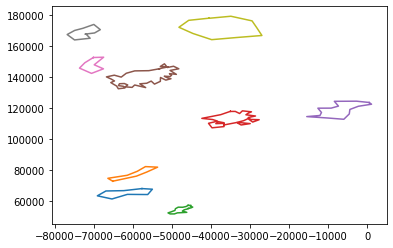

In [15]:
#from Autocad drawings of the reservoir make polygons
_points = getPointsFromSpline("autocadList")
r_names = ["Provenance", "Laxford", "Victory", "Cragganmore", "Colza", "Mull", "Bunnnehaven", "Tobermory", "Lyon" ]
d=[]
for i, rpoints in enumerate(_points):
    poly = geometry.Polygon([[p[0], p[1]] for p in rpoints])
    _d = {"reservoir": r_names[i],
         "polygon": poly}
    d.append(_d)
df = pd.DataFrame(d)

# specify number of the wells per reservoir
df["no_wells"] = [1, 1, 1, 4, 2, 4, 1, 1, 6]

#place wells in a random position within the reservoir polygon
_w_loc = []
for i, res in enumerate(df.values):
    _w_loc.append(random_wells_in_polygon(res[2], res[1]))
df["wells_loc"] = _w_loc

# make a list of wells to use later
w_loc = []
wells = []
for index, p in list(df.iterrows()):
    for p2 in p[3]:
        w_loc.append({"res_index":index, "x":p2.x, "y":p2.y})
        wells.append((p2.x, p2.y))
df2=pd.DataFrame(w_loc)
wells =np.array(wells)
# print(df2.head())

In [17]:
df

,reservoir,polygon,no_wells,wells_loc
0,Provenance,POLYGON ((-57630.80375154148 68099.57581171501...,1,[POINT (-56075.05700437741 65290.01644444446)]
1,Laxford,POLYGON ((-65115.21754158869 72860.95652708251...,1,[POINT (-55765.65782429989 81042.85350781072)]
2,Victory,POLYGON ((-45827.09270078488 57297.87845145001...,1,[POINT (-46010.87968074223 55387.94544337507)]
3,Cragganmore,"POLYGON ((-35010.24282495898 117852.49207179, ...",4,"[POINT (-32097.60676353113 114364.2985740556),..."
4,Colza,"POLYGON ((505.7645901516165 123580.59960582, -...",2,"[POINT (-6711.81152915072 121605.4939347545), ..."
5,Mull,"POLYGON ((-53164.29723210438 145299.935793285,...",4,"[POINT (-59006.7374758345 135197.3426504473), ..."
6,Bunnnehaven,POLYGON ((-70076.25883539829 152544.5241086025...,1,[POINT (-73139.87179319667 145675.9484774045)]
7,Tobermory,POLYGON ((-71927.25198519688 167604.2028912825...,1,[POINT (-71951.09498691239 165308.8466689403)]
8,Lyon,POLYGON ((-40522.95469225149 177869.2234928175...,6,"[POINT (-39697.12184012844 174899.7277640577),..."


In [16]:
wells

array([[-56075.05700438,  65290.01644444],
       [-55765.6578243 ,  81042.85350781],
       [-46010.87968074,  55387.94544338],
       [-32097.60676353, 114364.29857406],
       [-35397.04155624, 115581.72902767],
       [-38161.10523258, 111507.67194936],
       [-37625.52937341, 114908.03026175],
       [ -6711.81152915, 121605.49393475],
       [ -9325.08111473, 118397.85322556],
       [-59006.73747583, 135197.34265045],
       [-54943.43229178, 142547.81731379],
       [-61077.63728068, 134864.90841371],
       [-60885.36628176, 138495.81521021],
       [-73139.8717932 , 145675.9484774 ],
       [-71951.09498691, 165308.84666894],
       [-39697.12184013, 174899.72776406],
       [-41136.72233216, 170921.22166658],
       [-45751.83433155, 174322.61378737],
       [-40565.92751021, 166035.63429819],
       [-38148.28978879, 175248.8394016 ],
       [-40514.92367   , 170301.19535806]])

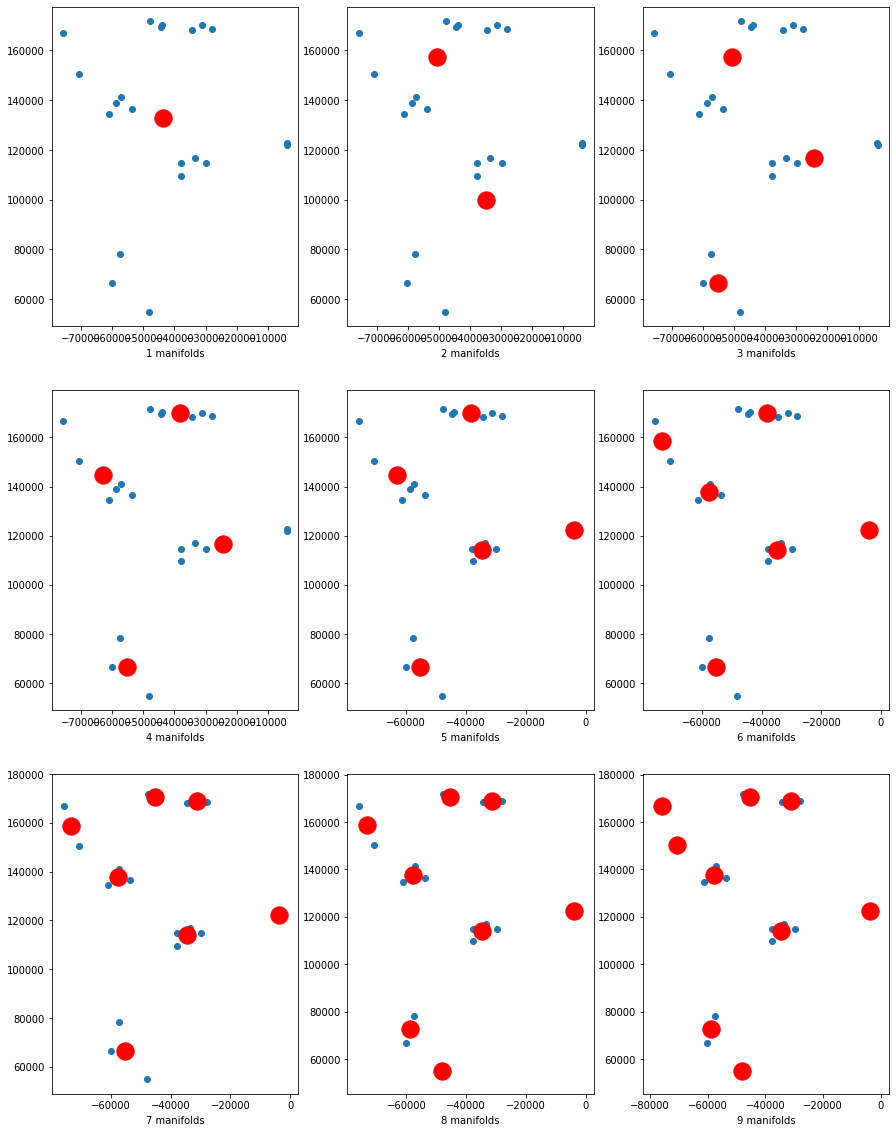

In [16]:
# check how many manifols to use
m_l = testManifoldLocations(wells,9)

In [17]:
m_l[5]["locations:"]

array([[-57696.92851883, 137758.52865335],
       [-38270.14133892, 169807.1348368 ],
       [-34693.25859297, 114008.12094652],
       [-55224.19094855,  66592.57113007],
       [ -3867.32454328, 122392.06084135],
       [-73257.55877613, 158650.70783171]])

### Define how many lines to use and their path ??
For now criteria = min length with and max length of each line to be 200km
i.e. if one line length is more then 200km two lines will be checked. And if the locations of manifolds are
in opposite directions maybe more lines will return the min lenght. So we do a loop and stop with the min 
overall lenght of the lines. 

Maybe best to connect the sortest distance to the manifold with most production and the rest to tie into the line?

3 lines solution line 0 length is 181864
3 lines solution line 1 length is 139482
3 lines solution line 2 length is 181784
2 lines solution line 0 length is 216857
2 lines solution line 1 length is 167005
1 lines solution line 0 length is 284989


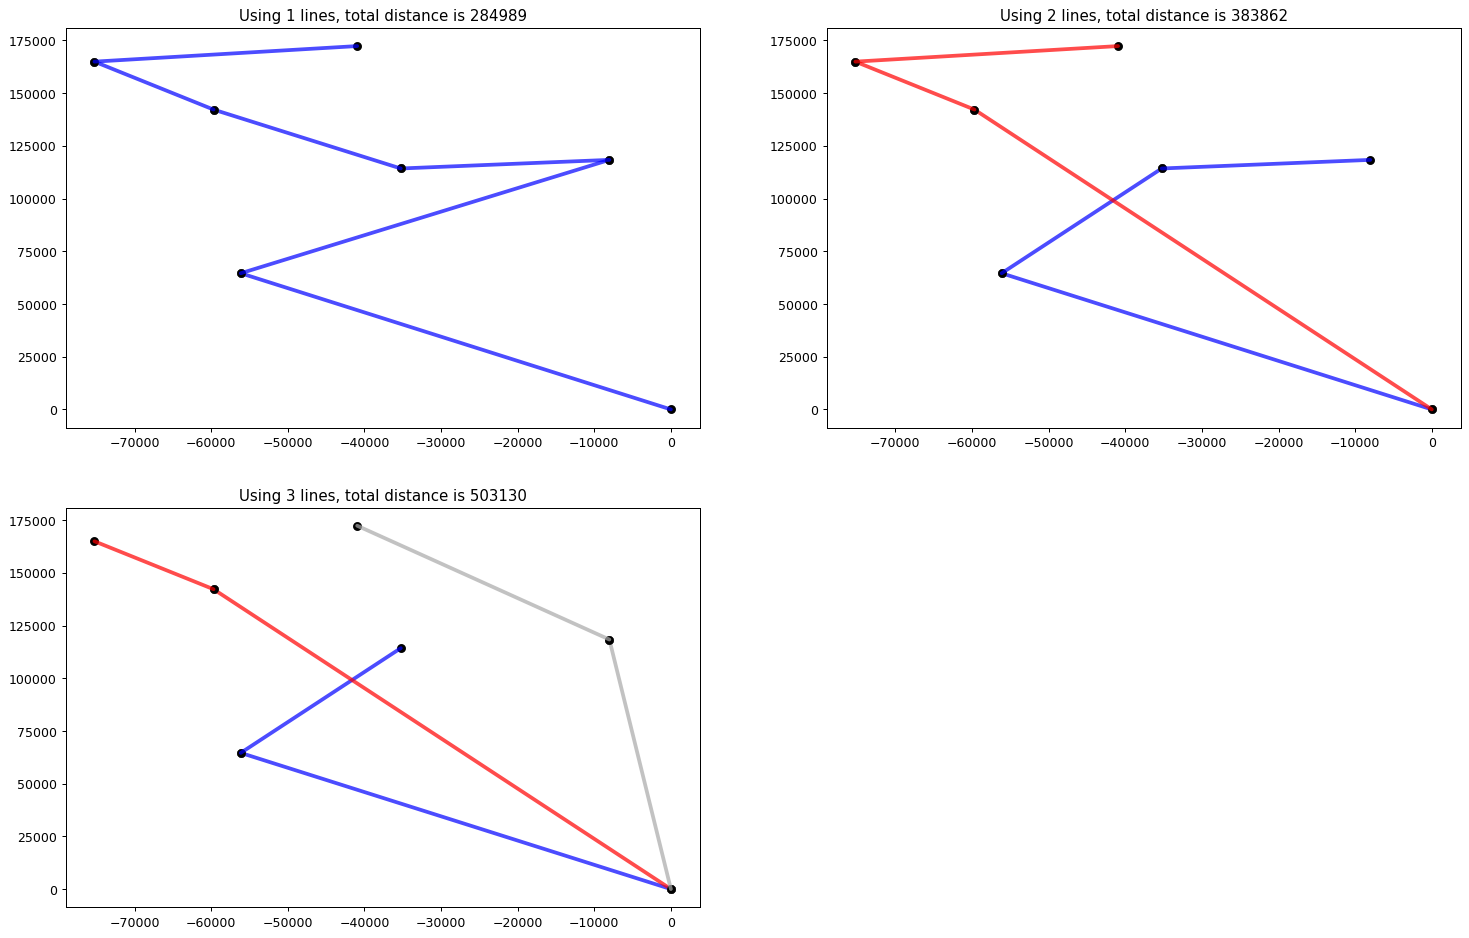

In [13]:
# points_2dList = [(x["x"],x["y"]) for x in points]
from shapely.figures import SIZE, set_limits, plot_coords, plot_bounds, plot_line
SIZE = (20,20)
col_l=["BLUE","RED","DARKGRAY","GREEN"]
fig = pyplot.figure(1, figsize=SIZE, dpi=90)

points_2dList = m_l[5]["locations:"].tolist()
points_2dList.insert(0,[0.0,0.0])

maxLength = 500000
for i in range(3,0,-1):
    ax = fig.add_subplot(320+i)
    paths, total_distance = getPath(points_2dList,i,maxLength)
#     print(f"with {i} lines, total distance is {total_distance}")
    ax.set_title(f"Using {i} lines, total distance is {total_distance}")
    _l=[]
#     print(len(paths))
    for k in range(i):
        col=col_l[k]
        for j, p in enumerate(paths[k]["path"][:-1]):
            _line = connect(paths[k]["path"][j], paths[k]["path"][j+1])
            _l.append(_line)
            plot_coords(ax,_line)
            plot_bounds(ax,_line)
            plot_line(ax,_line, alpha=0.7,color=col)
            dist = paths[k-1]["distance"]
        print(f"{i} lines solution line {k} length is {dist}")
plt.show()

## HOLD 
### 1. how to chose number of manifolds?
### 2. how to chose the line path?
### 3. if multiple lines does every line needs 4 PDG?
### 4. sizing of lines - currently taken as 30in

### Gas line
1. Connect Manifolds using 30in line PLET to PLET, and HOLD Jumper
2. Put PDGS as ILT at desired locations on the line
3. If PDGS is located within 50m of Manifold then no need to add aditional PLETs and connect PDGS directly to Manifold with rigid jumper. 

In [18]:
# calculate OD - idealy this should be complex function but for now
# 1. check the max od from the installation standpoint
# 2. take if installation allows 30in for less than 600mmscfd and 32in if more than 600mmscfd
od = calcOd(fluid, line)
line["od"]= od *25.4 /1000

# calculate inlet pressure using simple pressure drop calc
pInlet = pArrival + calPressureDrop(fluid,line,pArrival) * line["length"]
print(f"For given arrival pressure of {pArrival/10**5}bar calculated inlet pressure is {pInlet/10**5} bar")

#use design factor as 1.25 times the inlet pressure for wt calculations
p_design = pInlet * 1.25
line["design pressure"] = p_design
# calculate wall thickness
wt = calWt(fluid, line, p_design)
line["wallThickness"] = wt

Friction factor is 5.7347
For given arrival pressure of 70.0bar calculated inlet pressure is 111.7797692566487 bar
from operation 0.019460111308605785 m
from hydrotest 0.020017547811020626 m
from installation/shutdown 0.01858264486607143 m
Min water depth is -54.0546m and maximum is 1640.0m
Min wt is 20.017547811020627 mm


In [152]:
import thermo
import fluids
P1 = 110e5
temp=fluid["temperature"]
epsilon = line["pipeRoughness"]
Qst = fluid["flowRate"]*1e6/(86400*35.3147) # mmscfd to m3/sec at standard coditions
S0=thermo.Stream('natural gas', T=15+273.15, P=101325, Q=Qst)
S1=thermo.Stream('natural gas', T=temp+273.15, P=P1, n=S0.n)
print(f"Flow rates, standard condition {S0.Q}m3/s {S0.m}kg/s, actual {S1.Q}m3/s {S0.m}kg/s")
# m3/sec at actual coditions, needs to be in the iteration because temp, pressure and Z are fuction of p and T
D=line["id"]
L=16100
for i in range(10):
    S2 = thermo.Stream('natural gas', P=0.5*(P2+S1.P), m=S1.m)
    V = S2.Q/(math.pi/4*D**2)
    Re = S2.Reynolds(D=D, V=V)
    fd = friction_factor(Re=Re, eD=epsilon/D)
    P2 = fluids.isothermal_gas(rho=S2.rho, fd=fd, P1=S1.P, D=D, L=L, m=S1.m)/1e5
    print('%g' %P2)
#     Qac = ( Qst * 1e5* fluid["Compressibility  Factor"]*(fluid["temperature"]+273.15))  / (pressure*288.71) 
# Qac

Flow rates, standard condition 163.87048557787656m3/s 116.74154605933394kg/s, actual 1.8750410115400888m3/s 116.74154605933394kg/s
106.922
103.236
103.236
103.236
103.236
103.236
103.236
103.236
103.236
103.236


In [136]:
fluid["Compressibility  Factor"]

1

In [135]:
fluid["flowRate"]*1e6/(86400*35.3147)
(1e5* fluid["Compressibility  Factor"]*(fluid["temperature"]+273.15)) / (pressure*288.71)
S1= thermo.Stream('natural gas', T=fluid["temperature"]+273.15, P=P1, Q=Qac)
print(S1)

<Stream, components=['methane', 'nitrogen', 'carbon dioxide', 'ethane', 'propane', 'isobutane', 'butane', '2-methylbutane', 'pentane', 'hexane'], mole fractions=[0.9652, 0.0026, 0.006, 0.0182, 0.0046, 0.001, 0.001, 0.0005, 0.0003, 0.0007], mole flow=11514.480033592601 mol/s, T=383.15 K, P=11000000 Pa>


In [ ]:
S1 = thermo.Stream('natural gas', P=P1, m=m)
V = S1.Q/(math.pi/4*D**2)
Re = S1.Reynolds(D=D, V=V)
fd = fluids.friction_factor(Re=Re, eD=epsilon/D)
print(f"rho={S1.rho}, fd={fd}, P1={S1.P}, D={D}, L={L}, m={S1.m}, Re={Re}, V={V}")
P2 = fluids.isothermal_gas(rho=S1.rho, fd=fd, P1=S1.P, D=D, L=L, m=S1.m)
P2
for i in range(10):
    S2 = Stream('natural gas', P=0.5*(P2+S1.P), m=m)
    V = S2.Q/(pi/4*D**2)
    Re = S2.Reynolds(D=D, V=V)
    fd = friction_factor(Re=Re, eD=epsilon/D)
    P2 = isothermal_gas(rho=S2.rho, fd=fd, P1=S1.P, D=D, L=L, m=S1.m)
    print('%g' %P2)

In [44]:
#using fluid library to do calculations
import fluids

pressure = pArrival
velocity = fluid["flowRate"]*math.pow(10,6)/((86400*35.3147)*math.pi/4*math.pow(line["id"],2))* math.pow (10,5)* fluid["Compressibility  Factor"]*( fluid["temperature"]+273.15)/ pressure/288.71;
re=fluid["density"]*velocity*line["id"]/fluid["viscosity"];
pRo = line["pipeRoughness"]
pRo2 = fluids.friction.material_roughness('gas pipe', line["id"])
print(pRo,pRo2)
f = colebrook.sjFriction( re, pRo)

f2 = fluids.friction.Colebrook(re,pRo2)

print(fluid["flowRate"])
print(f"Re={re}, Velocity={velocity}m/s, Friction factor is {f,f2}")
pressureDrop_unit = -fluid["density"]*9.81*math.sin(line["angle"]*math.pi/180)-f*fluid["density"]*math.pow(velocity,2)/(2*line["id"])
print(pressureDrop_unit)    
# fd=line["pipeRoughness"]
P2=pArrival
D=line["id"]
L=line["length"]
mmscfd = 1177.17 #m3/hr
rho=fluid["density"]
fd=f
m=fluid["flowRate"]*mmscfd * fluid["density"]/60/60 #kg/s
print(f"rho={rho}, fd={fd}, P2={P2}, D={D}, L={L}, m={m}")
#isothermal_gas(rho=11.3, fd=0.00185, P1=1E6, D=0.5, L=1000, m=200)
fluids.isothermal_gas(rho=rho, fd=fd, P2=70e5, D=D, L=L, m=m)

0.0045 0.0014
500
Re=5958.636452900938, Velocity=7.418030003711031m/s, Friction factor is (0.0415, 0.03722574984692974)
18.142048379907376
rho=2.2, fd=0.0415, P2=7000000, D=0.73024, L=194742.6263587469, m=359.69083333333333


Exception: The desired mass flow rate of 359.690833 kg/s cannot be achieved with the specified downstream pressure; the maximum flowrate is nan kg/s at an upstream pressure of inf Pa

In [66]:
fluids.friction.nearest_material_roughness("gas pipeline")
fluids.nearest_pipe(NPS=30,schedule="STD")

(30, 0.74294, 0.762, 0.009529999999999999)

In [77]:
fluids.P_isothermal_critical_flow(P=110E5, fd=0.00185, L=200000., D=0.730)/1e5

4.851459184051316

In [103]:
fluids.isothermal_gas(rho=11.3, fd=0.00185, P1=110E5, L=60000, D=0.730, m=359)/1e5

32.151317721046965

In [70]:
pipe_schedules = ['5', '10', '20', '30', '40', '60', '80', '100', '120', '140', '160', 'STD', 'XS', 'XXS', '5S', '10S', '40S', '80S']
for sch in pipe_schedules:
    try:
        print(fluids.piping.nearest_pipe(NPS=30, schedule=sch), sch)
    except Exception:
        pass

(30, 0.7493, 0.762, 0.00635) 5
(30, 0.7461599999999999, 0.762, 0.00792) 10
(30, 0.7366, 0.762, 0.0127) 20
(30, 0.73024, 0.762, 0.015880000000000002) 30
(30, 0.74294, 0.762, 0.009529999999999999) STD
(30, 0.7366, 0.762, 0.0127) XS
(30, 0.7493, 0.762, 0.00635) 5S
(30, 0.7461599999999999, 0.762, 0.00792) 10S


In [92]:
fluids.isothermal_gas(rho=11.3, fd=0.00185, P1=1E6, D=0.5, L=100, m=200)/1e5

9.810812480292153

In [113]:
from fluids.units import *


UndefinedUnitError: 'mmscfd' is not defined in the unit registry

In [ ]:
S1

In [ ]:
1e5

###  PDGS units
1. 1st manifold location
2. major low point
3. 30% of the line from the field
4. 50% of the line from the field
5. If any PGDS unit is 2000m from another then do not place this unit. 

In [ ]:
pds=[]
# 1. 1st manifold location
# problem is here how to identify the first manifold?
# Approach 1 - make a min path between the end point and manifolds and take the last item. 
# Approach 2 - HOLD to discuss - maybe take the manifold with the highest flow rate?
pds.append(paths[0]["path"][-1])
# 2. major low point
x= min(_line, key=lambda x: x["z"])["x"]
y= min(_line, key=lambda x: x["z"])["y"]
pds.append((x,y))
# 3. 30% of the line from the field
x = list(path.interpolate(1-0.3, normalized=True).xy[0])[0]
y = list(path.interpolate(1-0.3, normalized=True).xy[1])[0]
pds.append((x,y))
# 4. 50% of the line from the field
x = list(path.interpolate(0.5, normalized=True).xy[0])[0]
y = list(path.interpolate(0.5, normalized=True).xy[1])[0]
pds.append((x,y))
print(f"Locations for PDS units are {pds}")

### Main line pump Skid
1. Place at the same place with the 50% main line PDS
2. Connect MLP with Water Line PLET/ILT with 8in rigid jumper 

In [ ]:
# at the same place with the 50% main line PDS
mlp = [pds[-1]]
print(f"Locations for Main Pump is {mlp}")

### Water line
1. Criteria velocity = 1m/s, use flowrate from wells and double it for the MEG
2. Place one Pump Skid at every PGDS unit
3. Connect Pump Skid to PGDS with 2in flexible
4. Connect Pump Skid to Water Line PLET/ILT with 2in flexible 

In [ ]:
# place a small pump close to every PDG unit expect the unit that has main line pump and connect
# all pumps with the 8 in line
w_line = {
    "od": 8*25.4/1000
}

### Umbilical line
1. Place SDU at every manifold location
2. At every Pump Skid location if not within 300m from the SDU split umbilical by pair of UTA and connect UTA with Pump Skid by HFL, EFL
3. Connect Pump Skid and PGDS by HFL, EFL
4. Connect SDU with Manifolds and Pump Skids (within 300m) by HFL, EFL
5. Connect every Xmas with the nearest SDU with (HFL, EFL, MEGFL) -> UTA -> Infiled Umbilical -> UTA -> (HFL, EFL, MEGFL)
6. Connect SDU with MEG PLET/ILT by MEGFL

### MEG line

In [ ]:
#HOLD calculation for qty needed
# 
m_line = {
    "od": 6*25.4/1000
}

## Plot results

In [ ]:
rows_list = []
for row in pds:
        dict1 = {}
        aa = {"x": row[0],
             "y": row[1],
             "z": 0,
             "type": "pdg unit",
             "kp": "na"}
        dict1.update(aa) 
        rows_list.append(dict1)
for row in mlp:
        dict1 = {}
        aa = {"x": row[0],
             "y": row[1],
             "z": 0,
             "type": "main pump",
             "kp": "na"}
        dict1.update(aa) 
        rows_list.append(dict1)
for row in manifolds:
        dict1 = row
        aa = { "type": "manifold",
             "kp": "na"}
        dict1.update(aa) 
        rows_list.append(dict1)        
for row in endPoint:
        dict1 = row
        aa = { "type": "end point",
             "kp": "na"}
        dict1.update(aa) 
        rows_list.append(dict1)  
for index, row in enumerate(_line):
        dict1 = row
        aa = { "type": "main line",
             "kp": kp[index]}
        dict1.update(aa) 
        rows_list.append(dict1) 

df = pd.DataFrame(rows_list)       
df


In [ ]:
import seaborn as sns
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
markers = {"pdg unit": "s", "main pump": "X"}
sns.scatterplot(x="x", y="y", data=df, hue="type", size="type", markers=markers, s=20)

In [116]:
# location of ILT for future connections
# https://www.maa.org/press/periodicals/convergence/historical-activities-for-calculus-module-3-optimization-herons-shortest-distance-problem
from sympy import solve, Poly, Eq, Function, exp, Symbol, diff, root
from sympy.abc import x, y, z, a, b
f = Function('f')
# x = Symbol('x')
A = (0,4) # future manifold location
B = (10,12) # location of the end point
azimuth = math.radians(-30)
fC= x/math.tan(azimuth)
C = (x,fC) # equation of the line where ILT should be
f = root(((A[0]-C[0])**2+(A[1]-C[1])**2),2 ) + root(((B[0]-C[0])**2 +( B[1]-C[1])**2),2)
f


sqrt(x**2 + (1.73205080756888*x + 4)**2) + sqrt((10 - x)**2 + (1.73205080756888*x + 12)**2)

In [117]:
df = diff(f,x)
df 

(4.0*x + 6.92820323027551)/sqrt(x**2 + (1.73205080756888*x + 4)**2) + (4.0*x + 10.7846096908265)/sqrt((10 - x)**2 + (1.73205080756888*x + 12)**2)

In [123]:
Cx = solve(diff(f,x))
x=Cx
eval(fC)

TypeError: eval() arg 1 must be a string, bytes or code object

In [126]:
fC

False

In [122]:
solve(fC,x=Cx)

[0.0]

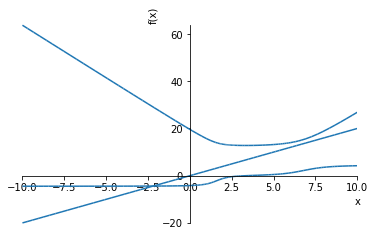

In [101]:
from sympy.plotting import plot
p1=plot(f, show=False)
p2=plot(df, show=False)
p3=plot(fC, show=False)
p1.append(p2[0])
p1.append(p3[0])
p1.show()

In [87]:
import numpy as np  
import matplotlib.pyplot as plt  
def graph(formula, x_range):  
    x = np.array(x_range)  
    y = eval(formula)
    plt.plot(x, y)  
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (21,) and (1,)

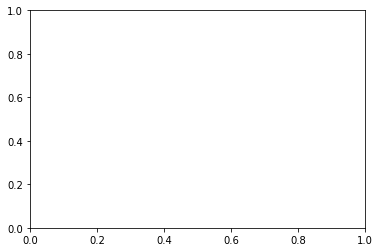

In [90]:
graph('f', range(-10, 11))

In [ ]:
# test line adustment
xls = pd.ExcelFile('path_to_file.xls')
df1 = pd.read_excel(xls, 'Sheet1')
df2 = pd.read_excel(xls, 'Sheet2')

In [127]:
!pip install pyproj

     |████████████████████████████████| 10.1MB 4.3MB/s eta 0:00:01| 2.7MB 4.3MB/s eta 0:00:0200:02��██████████            | 6.3MB 4.3MB/s eta 0:00:01�██████▌         | 7.1MB 4.3MB/s eta 0:00:01
ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/lib64/python3.6/site-packages/pyproj'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'pip install --upgrade pip' command.


In [128]:
import pyproj

In [4]:
for i in range(5):
    print(f"Hello {i+1}")

Hello 1
Hello 2
Hello 3
Hello 4
Hello 5


In [2]:
def funks(od=1,wt=5):
    return od*2+wt
    

In [14]:
funks(wt=0)

2

In [1]:
dic=[{"name":"Mobilisation","properties":{}},{"name":"Base Mobilisation","properties":{}},{"name":"Demobilisation","properties":{}},{"name":"Base Demobilisation","properties":{}},{"name":"Installation","properties":{}},{"name":"Pipelay","properties":{"offset":80}},{"name":"Pre-commissioning","properties":{"location":0,"color":255}},{"name":"Survey","properties":{"length":20,"height":50,"color":2097152}},{"name":"Metrology","properties":{"numberOfTransponders":20,"circleRadius":50,"color":250}},{"name":"Transit","properties":{}},{"name":"Stand by","properties":{}},{"name":"Pre-Cut trenching","properties":{"length":20,"height":50,"color":125}},{"name":"Backfilling","properties":{"length":20,"height":50,"color":125}},{"name":"Engineering","properties":{}},{"name":"Fabrication","properties":{}},{"name":"Spooling","properties":{}},{"name":"Support","properties":{}},{"name":"Transport","properties":{}}]
for i in dic:
    print(i['name'])

Mobilisation
Base Mobilisation
Demobilisation
Base Demobilisation
Installation
Pipelay
Pre-commissioning
Survey
Metrology
Transit
Stand by
Pre-Cut trenching
Backfilling
Engineering
Fabrication
Spooling
Support
Transport
